# False Positive predictions for single/double-transit Kepler signals 

The following analysis was executed using commit `e4f54288` of the [exosyspop](github.com/timothydmorton/exosyspop) module.

## Setup

In [1]:
%matplotlib inline
from __future__ import print_function, division

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up plot stuff the DFM way:
%run ../peerless/plot_setup.py

# Retrieve the target catalog
!../scripts/peerless-targets

from peerless.catalogs import TargetCatalog, EBCatalog, KICatalog
targets = TargetCatalog().df
targets.index = targets.kepid

# Some targets have missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

# Calculate galactic latitude of target stars, for later use.
from astropy.coordinates import SkyCoord
c = SkyCoord(targets.ra, targets.dec, unit='deg')
targets['b'] = c.galactic.b.deg

# Download (or load) BG star simulation of the middle of the Kepler field, using TRILEGAL, via vespa
try:
    bgstars = pd.read_hdf('bgstars.h5', 'df')
except:
    from vespa.stars.trilegal import get_trilegal    
    get_trilegal('bgstars.h5', 290.6654895, 44.48410232)
    bgstars = pd.read_hdf('bgstars.h5', 'df')

Saving 39036 targets to /Users/tdm/peerless/catalogs/targets.csv


## Calibrate EB population parameters to match Kepler EB catalog

136.401367662
EB: dmag regressor trained, R2=0.999481037605
EB: qR regressor trained, R2=0.999475105147
145


/Users/tdm/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


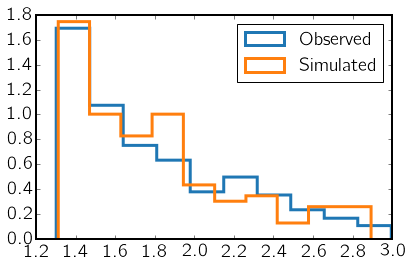

In [2]:
from exosyspop.populations import KeplerPowerLawBinaryPopulation

# Initialize population object
ebpop = KeplerPowerLawBinaryPopulation(targets)

# These parameters have been found to work well
min_period = 20
max_period = 25*365.25
fB = 0.25
beta = -1.0
ebpop.set_params(beta=beta, period_min=min_period, period_max=max_period, fB=fB)

# Query to emulate Kepler EB selection: less than 1000 days;
#  both primary and secondary eclipse found, or greater than two of either;
#  duration less than 2.5 days.
q = 'period > {} and period < 1000 and '.format(min_period) +\
    '((n_pri > 0 and n_sec > 0) or ' +\
     '(n_pri > 2 or n_sec > 2)) and (T14_pri < 2.5 or T14_sec < 2.5)'

kep_ebs = EBCatalog().df.query('{} < period < 1000'.format(min_period))
n_exp = len(kep_ebs) * (len(targets)/len(KICatalog().df))
print(n_exp)
plt.hist(np.log10(kep_ebs.period), 
         histtype='step', lw=3, normed=True, label='Observed');
new_obs = ebpop.observe(new_orbits=True).query(q)
plt.hist(np.log10(new_obs.period), label='Simulated',
        histtype='step', lw=3, normed=True);
plt.legend()
print(len(new_obs))

In [3]:
ebpop.params

{'beta': -1.0,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.25,
 'gamma': 0.3,
 'period_max': 9131.25,
 'period_min': 20,
 'qmin': 0.1}

OK, the above parameters qualitatively match the period distribution well, what about the total number of detections?  Let's do a bunch of these observation simulations and confirm it looks good:

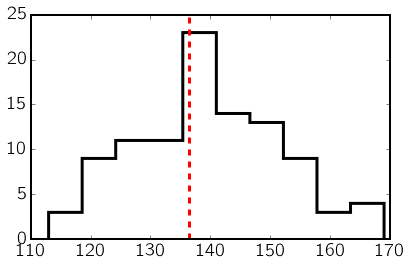

In [4]:
n_obs = [len(ebpop.observe(new_orbits=True).query(q)) for i in range(100)]

plt.hist(n_obs, histtype='step', lw=3, bins=10, color='k');
plt.axvline(n_exp, color='r', ls='--', lw=3);

## Define EB and BEB populations with these parameters.

Now that we can roughly match the Kepler EB catalog from 20 to 1000d with these EB population parameters, we want to know what's the typical number of single/double eclipse signals.

In [5]:
# Define a BEB population
from exosyspop.populations import TRILEGAL_BGPowerLawBinaryPopulation

ebpop = KeplerPowerLawBinaryPopulation(targets)
bgpop = TRILEGAL_BGPowerLawBinaryPopulation(targets, bgstars, use_ic=True)

In [6]:
# Set params to match above
pars = dict(period_min=min_period, period_max=max_period, beta=beta, fB=fB)
ebpop.set_params(**pars)
bgpop.set_params(**pars)

## Just 
#ebpop._generate_binaries()
#bgpop._generate_binaries()

In [7]:
# Train the regressions; calling explicitly allows to do this with N=1000 rather than N=10000
ebpop._train_trap(N=1000);
bgpop._train_trap(N=1000);

EB: dmag regressor trained, R2=0.999500036883
EB: qR regressor trained, R2=0.99947245989
EB: Depth trained: R2=0.999702660929
EB: Duration trained: R2=0.998343729032
EB: Slope trained: R2=0.983507073922
BGEB: Depth trained: R2=0.998040263779
BGEB: Duration trained: R2=0.992783188554
BGEB: Slope trained: R2=0.989069626741


## Simulate detected populations of EBs and BEBs

Here, we simulate how many EBs and BEBs will be typically detected with 

* only primary OR secondary eclipses showing
* fewer than 3 eclipses 
* SNR > 15
* duration < 2.5d

In [8]:
n_sim = 100
dfm_q = 'n_pri < 3 and n_sec < 3 and ' +\
        '(((n_pri==0 or snr_pri < 15) and snr_sec > 15) or ' +\
        '((n_sec==0 or snr_sec < 15)  and snr_pri > 15))'
dfm_q += ' and ((T14_pri < 2.5 and n_pri > 0) or (T14_sec < 2.5 and n_sec > 0))'
nobs_eb = [len(ebpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(n_sim)]
nobs_bg = [len(bgpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(n_sim)]

(7.2300000000000004,
 2.5054141374231924,
 (0.40999999999999998, 0.58472215624174884))

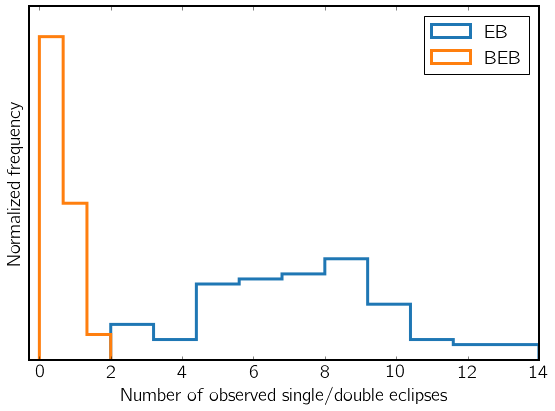

In [26]:
plt.figure(figsize=(8,6))
plt.hist(nobs_eb, histtype='step', lw=3, label='EB', bins=10)
plt.hist(nobs_bg, histtype='step', lw=3, label='BEB', bins=3)
plt.legend();
plt.xlim(xmin=-0.3)
plt.yticks([])
plt.ylabel('Normalized frequency')
plt.xlabel('Number of observed single/double eclipses');
plt.savefig('N_EBs.pdf', bbox_inches='tight')
(np.mean(nobs_eb), np.std(nobs_eb), (np.mean(nobs_bg), np.std(nobs_bg)))

## Simulate detected population of planets

As a good sanity check, let's make sure we reproduce the detected population of planet signals, given the population model constrained in the paper.

In [10]:
# Here, defining population to match what was fit for in the paper
from exosyspop.populations import PlanetPopulation

import astropy.constants as const
RJUP = const.R_jup.cgs
RSUN = const.R_sun.cgs
REARTH = const.R_earth.cgs

class LongPeriodPlanetPopulation(PlanetPopulation):
    """
    Poisson Population in two bins: 0.1-0.4 RJup and 0.4-1.0 RJup
    
    From 2 to 25 years, with beta eccentricity distribution
    """
    min_period = 2*365.25
    max_period = 25*365.25
    
    vol1 = (np.log(0.4) - np.log(0.1))*(np.log(max_period) - np.log(min_period))
    vol2 = (np.log(1) - np.log(0.4))*(np.log(max_period) - np.log(min_period))
    
    param_names = ('Gam1', 'Gam2', 'beta_a', 'beta_b')
    default_params = {'Gam1':0.4, 'Gam2':0.18,
                      'beta_a':1.12, 'beta_b':3.09}
    
    def _sample_period(self, N):
        lo = np.log(self.min_period)
        hi = np.log(self.max_period)
        logp = np.random.random(N)*(hi - lo) + lo
        return np.exp(logp)
    
    def _sample_Np(self, N):
        Gam1, Gam2 = self._get_params(['Gam1', 'Gam2'])
        
        N_pl = Gam1*self.vol1 + Gam2*self.vol2 # Sum of both bins is total rate
        return np.random.poisson(N_pl, size=N)
    
    def _sample_Rp(self, N):
        Gam1, Gam2 = self._get_params(['Gam1', 'Gam2'])
        Nexp1 = Gam1*self.vol1
        Nexp2 = Gam2*self.vol2
        
        # Assign radii uniformly in each bin, with appropriate ratio given to each bin
        f1 = Nexp1 / (Nexp1 + Nexp2)
        u = np.random.random(N)
        in_1 = u < f1
        in_2 = u >= f1
        N1 = in_1.sum()
        N2 = in_2.sum()
        
        Rp = np.ones(N)
        lo1, hi1 = np.log(0.1), np.log(0.4)
        lo2, hi2 = np.log(0.4), np.log(1)
        Rp[in_1] = np.exp(np.random.random(N1)*(hi1 - lo1) + lo1)
        Rp[in_2] = np.exp(np.random.random(N2)*(hi2 - lo2) + lo2)
        return Rp * RJUP/RSUN

In [11]:
plpop = LongPeriodPlanetPopulation(targets)

plpop._train_trap(N=1000);
#_ = plpop.observe() # There was a point where this was necessary to avoid a bug...

Planet: Depth trained: R2=0.999350816606
Planet: Duration trained: R2=0.998843932513
Planet: Slope trained: R2=0.978945299494


OK, now let's load up the candidates, so we'll have something to compare to.

In [12]:
candidates = pd.read_csv('../results/fits.csv', index_col=0)

# add a few columns of interest
candidates['s2n'] = candidates.depth*1000/plpop.get_noise(candidates.index, candidates.duration) * np.sqrt(candidates.n_transits)
candidates['rstar'] = targets.ix[candidates.index, 'radius']

# convert depth from ppt to relative 
for p in ['depth', 'depth_uncert_minus', 'depth_uncert_plus']:
    candidates[p] *= 1e-3

# convert from hours to days
for p in ['duration', 'duration_uncert_minus', 'duration_uncert_plus']:
    candidates[p] /= 24. 

candidates[['depth','duration','period','radius','rstar','impact','n_transits','s2n']]

,depth,duration,period,radius,rstar,impact,n_transits,s2n
kicid,,,,,,,,
11709124,0.008777,0.739623,4.264997,0.828526,0.971,0.512708,1,103.742952
9306307,0.060297,0.354141,4.252540,1.220102,0.915,0.639900,1,424.324242
10321319,0.000374,0.701656,5.522778,0.163172,0.941,0.473659,1,15.994137
3239945,0.018865,0.675076,2.932872,0.875794,0.710,0.206589,2,402.787682
8410697,0.005724,0.823828,2.868810,0.698399,1.003,0.153588,2,148.615011
10287723,0.001458,0.395524,4.878759,0.265570,0.726,0.680744,1,26.992640
8426957,0.005522,1.640239,54.248522,1.039960,1.080,0.889371,1,127.168467
8738735,0.001237,1.143376,9.860707,0.354537,1.044,0.283580,1,19.297674
6551440,0.001072,0.452081,4.020863,0.281950,1.096,0.604324,1,20.423233


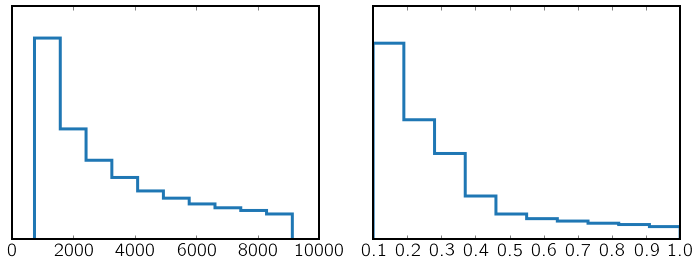

In [13]:
# Check out the period and radius distributions of the planets in this population

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(plpop.period, histtype='step', lw=3);
ax1.set_yticks([])
ax2.hist(plpop.radius_B*RSUN/RJUP, histtype='step', lw=3);
ax2.set_yticks([]);

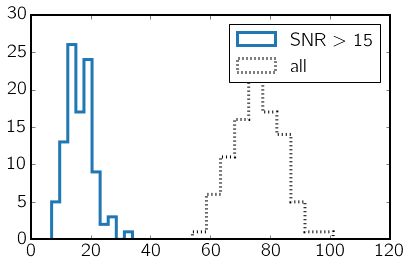

In [14]:
# Emulate detection criteria: fewer than three transits, SNR > 15, duration < 2.5d
dfm_q_pl = 'n_pri < 3 and snr_pri > 15 and T14_pri < 2.5'
dfm_q_pl_nosnr = 'n_pri < 3 and T14_pri < 2.5 and snr_pri > 0'

nobs_pl = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl)) for i in range(100)]
nobs_pl2 = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl_nosnr)) for i in range(100)]

plt.hist(nobs_pl, histtype='step', lw=3, label='SNR $>$ 15');
plt.hist(nobs_pl2, histtype='step', lw=3, color='k', ls=':', label='all')
plt.legend(loc='upper right');


In [15]:
# This matches up pretty well with what was actually detected
np.mean(nobs_pl), len(candidates.query('radius < 1.0'))

(16.579999999999998, 13)

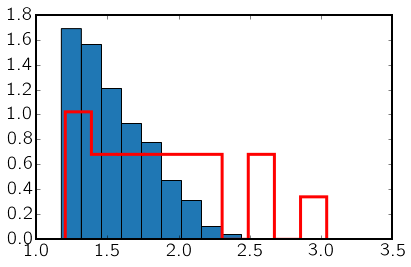

In [16]:
# Of course, this isn't an exact match because the detection/veto criteria
#  are much more complicated than SNR > 15...

# Simulate a large population of observed single/double transits
N = 1000
pl_obs = plpop.get_N_observed(query=dfm_q_pl, N=N)

plt.hist(np.log10(pl_obs.snr_pri), normed=True);
plt.hist(np.log10(candidates.s2n.values), histtype='step', color='r', lw=3, normed=True);

Let's put all the number-of-detections simulations together on the same plot:

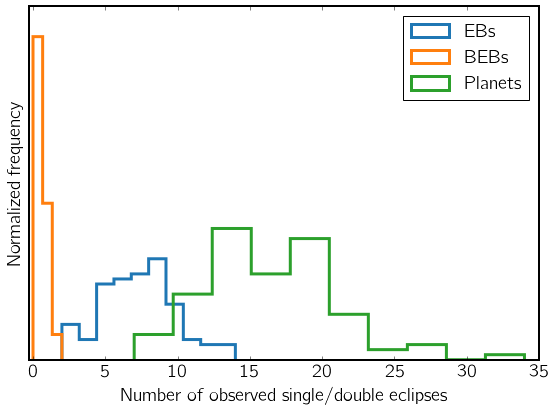

In [17]:
plt.figure(figsize=(8,6))
plt.hist(nobs_eb, histtype='step', lw=3, label='EBs', bins=10)#, bins=np.arange(16));
plt.hist(nobs_bg, histtype='step', lw=3, label='BEBs', bins=3)#, bins=np.arange(16));
plt.hist(nobs_pl, histtype='step', lw=3, label='Planets')
plt.legend();
plt.xlim(xmin=-0.3)
plt.yticks([])
plt.ylabel('Normalized frequency')
plt.xlabel('Number of observed single/double eclipses');
plt.savefig('N_predicted.pdf', bbox_inches='tight')

## Shape comparison

Now that we know the typical numbers of signals to expect, let's look at their typical shapes, and compare with the observed signals.

In [18]:
def plot_kde(kde, ax=None, dur_range=(0,2.), depth_range=(-3.5,-0.5), 
            cands=candidates, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    dur_grid = np.arange(dur_range[0], dur_range[1], 0.025)
    depth_grid = np.arange(depth_range[0], depth_range[1], 0.025)
    xx, yy = np.meshgrid(dur_grid, depth_grid)
    f = kde(np.vstack([xx.ravel(),yy.ravel()])).reshape(xx.shape)
    ax.imshow(f, origin='lower', extent=[dur_range[0], dur_range[1],
                                         depth_range[0], depth_range[1]], 
               aspect='auto', cmap='binary', interpolation='nearest',
               **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log$_{10}$(depth)')
    
    if cands is not None:
        xval = cands.duration
        xerr = [cands.duration_uncert_minus, cands.duration_uncert_plus]

        yval = np.log10(cands.depth)
        yerr = [yval - np.log10(cands.depth - cands.depth_uncert_minus),
                np.log10(cands.depth + cands.depth_uncert_plus) - yval]
        
        ax.plot(xval, yval, 'w.', ms=14)
        ax.plot(xval, yval, 'g.', ms=10)
        #ax.errorbar(xval, yval, xerr=xerr, yerr=yerr,
        #            color='g', marker='.', ms=10, ls='none', capsize=0)
        

In [19]:
# First, simulate large populations of EBs, BEBs
eb_obs = ebpop.get_N_observed(query=dfm_q, N=2000, new_orbits=True)
bg_obs = bgpop.get_N_observed(query=dfm_q, N=200, use_ic=True, new_orbits=True) #takes longer, so use fewer

In [20]:
from scipy.stats import gaussian_kde

eb_kde = gaussian_kde(np.array([eb_obs.observed.dur_pri, eb_obs.observed.logd_pri]))
bg_kde = gaussian_kde(np.array([bg_obs.observed.dur_pri, bg_obs.observed.logd_pri]))
pl_kde = gaussian_kde(np.array([pl_obs.observed.dur_pri, pl_obs.observed.logd_pri]))

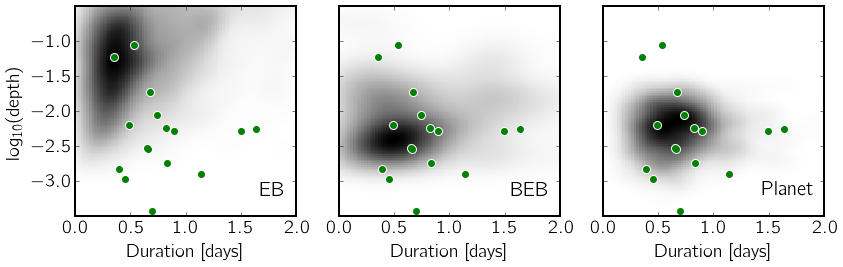

In [21]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
plot_kde(pl_kde, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB','Planet']):
    ax.set_yticks(np.arange(-3,-0.5,0.5))
    ax.annotate(title, xy=(0.95,0.1), xycoords='axes fraction', fontsize=20, ha='right')
    
plt.savefig('shape_kdes.pdf', bbox_inches='tight')

## False positive probabilities.

OK, now we can guess the nature of each individual signal, given our predicted rates and the depth-duration shape information.

In [44]:
pts = [candidates.duration, np.log10(candidates.depth)]
L_eb = eb_kde(pts)
L_bg = bg_kde(pts)
L_pl = pl_kde(pts)

pi_eb = 7.2
pi_bg = 0.41
pi_pl = 12 # for example.

norm = L_eb*pi_eb + L_bg*pi_bg + L_pl*pi_pl

candidates['pr_eb'] = L_eb*pi_eb / norm
candidates['pr_bg'] = L_bg*pi_bg / norm
candidates['pr_pl'] = L_pl*pi_pl / norm

In [49]:
candidates[['pr_eb', 'pr_bg', 'pr_pl']].sum()

pr_eb     2.726062
pr_bg     0.332295
pr_pl    12.941642
dtype: float64

In [46]:
candidates[['radius','depth', 'duration', 'pr_eb', 'pr_bg', 'pr_pl']]

,radius,depth,duration,pr_eb,pr_bg,pr_pl
kicid,,,,,,
11709124,0.828526,0.008777,0.739623,0.052284,0.010690,9.370254e-01
9306307,1.220102,0.060297,0.354141,0.995772,0.004219,8.714941e-06
10321319,0.163172,0.000374,0.701656,0.000205,0.000667,9.991277e-01
3239945,0.875794,0.018865,0.675076,0.250492,0.015676,7.338320e-01
8410697,0.698399,0.005724,0.823828,0.031286,0.015073,9.536416e-01
10287723,0.265570,0.001458,0.395524,0.031426,0.023016,9.455589e-01
8426957,1.039960,0.005522,1.640239,0.125445,0.075844,7.987111e-01
8738735,0.354537,0.001237,1.143376,0.003223,0.026579,9.701981e-01
6551440,0.281950,0.001072,0.452081,0.012068,0.014184,9.737478e-01


In [47]:
candidates[['pr_eb', 'pr_bg', 'pr_pl']].to_csv('../results/fpp.csv')

In [43]:
pi_eb = 2.21# 6.5
pi_bg = 0.22# 0.33
pi_pl = 13.57# 12 # for example.

norm = L_eb*pi_eb + L_bg*pi_bg + L_pl*pi_pl

candidates['pr_eb'] = L_eb*pi_eb / norm
candidates['pr_bg'] = L_bg*pi_bg / norm
candidates['pr_pl'] = L_pl*pi_pl / norm

candidates[['pr_eb', 'pr_bg', 'pr_pl']].sum()

pr_eb     2.213045
pr_bg     0.177410
pr_pl    13.609545
dtype: float64